## Google Stock Price Prediction
Classical machine learning approach.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout #type:ignore

## Load and preprocess data

In [10]:
df = pd.read_csv('GoogleStockPrices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.dropna()
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

## Create sequences for LSTM

In [11]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_close, seq_length)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Build and train LSTM model

In [12]:
model = Sequential([
    LSTM(50, return_sequences=True),  # First LSTM layer (returns sequences)
    Dropout(0.2),  #helps prevent overfitting
    LSTM(25, return_sequences=False),  # Second LSTM layer (final output)
    Dropout(0.2),  
    Dense(1)  # Output layer
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0376 - val_loss: 0.0027
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 9.1837e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 9.8695e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 9.0960e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

## Predict and inverse transform

In [13]:
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
dates_test = df['Date'].iloc[seq_length+split:]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## Model Metrics

The following metrics are used to evaluate the regression model's predictions: 
- RMSE (Root Mean Squared Error),
- MAE (Mean Absolute Error) and 
- R² (Coefficient of Determination) for prediction accuracy.

In [14]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

RMSE: 6.402675044202547
MAE: 5.219685622743405
R² Score: 0.9456720434494544


## Plot actual vs predicted prices

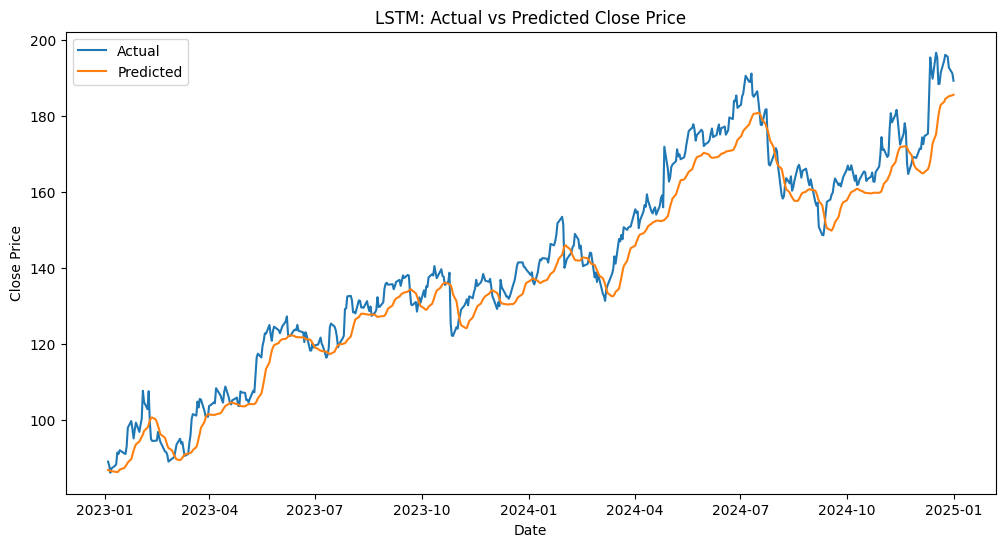

In [15]:
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_inv, label='Actual')
plt.plot(dates_test, y_pred_inv, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('LSTM: Actual vs Predicted Close Price')
plt.show()

## Investment Simulation

If you invest $250 on 2023-01-03, after 3 years you will have $531.03 (using LSTM predictions).


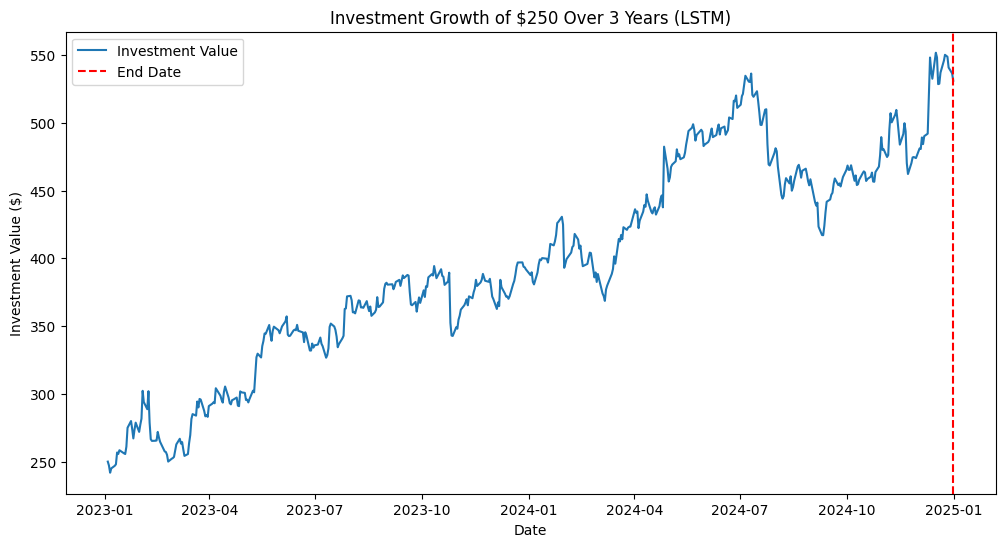

In [16]:
x_amount = 250  # Amount invested
y_years = 3  # Number of years

start_date = dates_test.iloc[0]
end_date = start_date + pd.DateOffset(years=y_years)
end_idx = dates_test.searchsorted(end_date)
if end_idx >= len(y_test_inv):
    end_idx = -1

start_price = y_test_inv[0][0]
end_price = y_test_inv[end_idx][0]
final_value = x_amount * (end_price / start_price)

print(f"If you invest ${x_amount} on {start_date.date()}, after {y_years} years you will have ${final_value:.2f} (using LSTM predictions).")

investment_growth = x_amount * (y_test_inv.flatten() / start_price)
plt.figure(figsize=(12,6))
plt.plot(dates_test, investment_growth, label='Investment Value')
plt.axvline(dates_test.iloc[end_idx], color='red', linestyle='--', label='End Date')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.title(f'Investment Growth of ${x_amount} Over {y_years} Years (LSTM)')
plt.legend()
plt.show()